In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler

from sklearn.cluster import DBSCAN
import time

In [79]:
labels_raw = [np.load('./labels/'+x) for x in os.listdir('./labels/') if x.endswith('.npy')]

label_dict = {}
value_array = []
for values in labels_raw:
    for value,ind in zip(values[0],values[1]):
        value_array.append(value)
        #print(value)
        label_dict[value] = ind

meta_data = pd.read_csv('cluster_meta.csv')
file_index = meta_data['cluster'].values

label_list = [label_dict[int(x[:-2])] for x in file_index]

meta_data.insert(6,'label',label_list)

meta_data = meta_data.drop(meta_data[meta_data['label'] == 4].index)
meta_data = meta_data.drop(meta_data[meta_data['label'] == 0].index)
meta_data['label'] = meta_data['label'] - 1



meta_data = meta_data.to_csv('cluster_meta_labels.csv', index = False)

In [80]:


meta_data = pd.read_csv('cluster_meta_labels.csv')
print(meta_data.head())

def load_data_with_label(folder_path, meta_data):
    data = []
    for file in meta_data['cluster']:
        if file.endswith('_A'):
            file = file + '.csv'
            file_path = os.path.join(folder_path,file)
            cluster = pd.read_csv(file_path,header=None).values
            cluster = cluster.flatten()
            # cluster = np.append(cluster, meta_data[meta_data['cluster'] == file[:-4]][['y', 'x', 'E', 'size']].values.flatten())
            data.append(cluster)
    combined_array = np.stack(data,axis=0)
    print('shape of combined array: ')
    print(combined_array.shape)
    return combined_array, meta_data[['y', 'x', 'E', 'size']].values, meta_data['label'].values




meta_scaler = RobustScaler()
meta_data_values = meta_scaler.fit_transform(meta_data[['y', 'x', 'E', 'size']])

folder_path = 'clusters_colour_rotations_rescaled'
combined_array, meta_data_values, meta_data_labels = load_data_with_label(folder_path, meta_data)

meta_data_labels = meta_data_labels.astype(int)

   Unnamed: 0   cluster     y     x          E   size  label
0           0  004580_A   9.0  26.0   715232.0  108.0      2
1           2  003882_A   3.0   3.0    31156.0    6.0      0
2           3  009717_G   7.0  62.0  1423016.0  245.0      2
3           4  005590_A  32.0  31.0  1014772.0  169.0      2
4           5  008859_G  13.0   9.0   397825.0   63.0      2
shape of combined array: 
(389, 4096)


In [81]:
import cv2

calculate hu moment of all combined arrays

In [82]:
print(combined_array.shape)
print(meta_data_values.shape)
combined_array = combined_array.reshape(389,64,64)
print(combined_array.shape)

im = combined_array[0]
print(im.shape)

# Calculate Moments 
moments = cv2.moments(im) 
# Calculate Hu Moments 
huMoments = cv2.HuMoments(moments)

print(huMoments[:,0])
print(meta_data.values[0])
new_meta = meta_data.values[0][2:6]
print(new_meta)

new_data, new_labels = [], []

for i in range(len(combined_array)):
    im = combined_array[i]
    moments = cv2.moments(im)
    huMoments = cv2.HuMoments(moments)
    new_meta = meta_data.values[i][2:6]
    new_data.append(np.concatenate((huMoments[:,0],new_meta)))
    new_labels.append(meta_data.values[i,-1])

new_data = pd.DataFrame(new_data, columns = ['hu1','hu2','hu3','hu4','hu5','hu6','hu7','y','x','E','size'])

(389, 4096)
(3112, 4)
(389, 64, 64)
(64, 64)
[ 4.03019650e-05  2.26270720e-15  1.55825086e-21  6.73334807e-20
 -2.48514844e-40  1.58452692e-27  6.43379782e-40]
[0 '004580_A' 9.0 26.0 715232.0 108.0 2]
[9.0 26.0 715232.0 108.0]


In [83]:
import lightgbm as lgb

In [84]:
X_train, X_test, y_train, y_test = train_test_split(new_data, new_labels, test_size=0.3, random_state=42)

In [85]:
model = lgb.LGBMClassifier(early_stopping_rounds=10, objective='multiclass')
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='binary_logloss')

y_pred = model.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))
print(np.sum(y_test == y_pred)/len(y_test))

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 272, number of used features: 9
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score -0.700527
[LightGBM] [Info] Start training from score -2.204605
[LightGBM] [Info] Start training from score -0.932973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

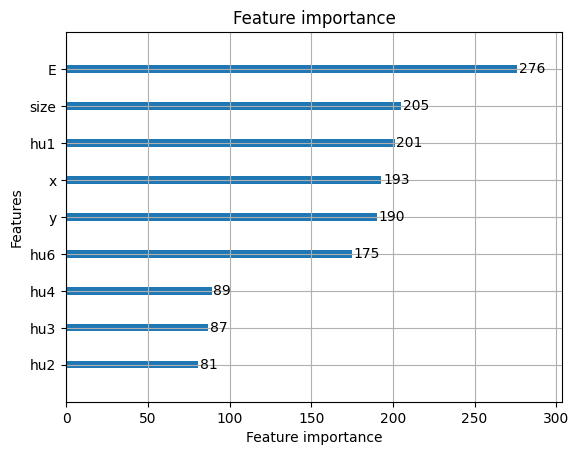

In [86]:
lgb.plot_importance(model)

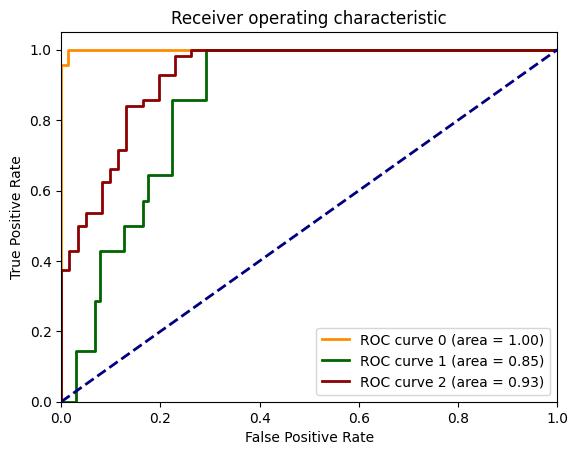

In [87]:
# #pred seperated by label
# print(np.unique(y_test))
# y0 = model.predict(X_test[np.array(y_test)==0])
# y1 = model.predict(X_test[np.array(y_test)==1])
# y2 = model.predict(X_test[np.array(y_test)==2])

#ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_test = label_binarize(y_test, classes=[0, 1, 2])
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='darkgreen',
            lw=lw, label='ROC curve 1 (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='darkred',
            lw=lw, label='ROC curve 2 (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [100]:
from umap import umap_ as UMAP

In [103]:

scaler = MinMaxScaler()
new_data = scaler.fit_transform(new_data)



In [111]:
new_data[-1,:] = np.abs(new_data[-1,:])
reducer = UMAP.UMAP()

embedding = reducer.fit_transform(new_data)

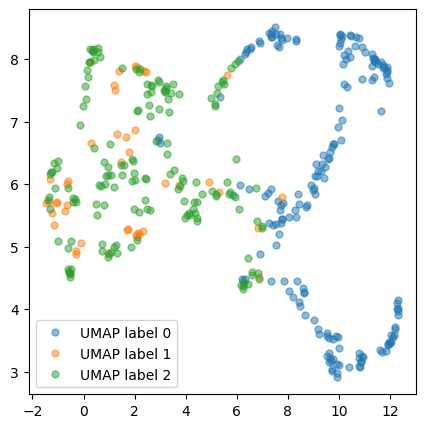

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(embedding[np.array(new_labels)==0, 0], embedding[np.array(new_labels)==0, 1], 'o', markersize=5, alpha=0.5, label='UMAP label 0')
ax.plot(embedding[np.array(new_labels)==1, 0], embedding[np.array(new_labels)==1, 1], 'o', markersize=5, alpha=0.5, label='UMAP label 1')
ax.plot(embedding[np.array(new_labels)==2, 0], embedding[np.array(new_labels)==2, 1], 'o', markersize=5, alpha=0.5, label='UMAP label 2')
ax.legend()

In [109]:
meta_data = pd.read_csv('cluster_meta.csv')
print(meta_data.head())

def load_data_with_label(folder_path, meta_data):
    data = []
    for file in meta_data['cluster']:
        if file.endswith('_A'):
            file = file + '.csv'
            file_path = os.path.join(folder_path,file)
            cluster = pd.read_csv(file_path,header=None).values
            cluster = cluster.flatten()
            # cluster = np.append(cluster, meta_data[meta_data['cluster'] == file[:-4]][['y', 'x', 'E', 'size']].values.flatten())
            data.append(cluster)
    combined_array = np.stack(data,axis=0)
    print('shape of combined array: ')
    print(combined_array.shape)
    return combined_array, meta_data[['y', 'x', 'E', 'size']].values




meta_scaler = RobustScaler()
meta_data_values = meta_scaler.fit_transform(meta_data[['y', 'x', 'E', 'size']])

folder_path = 'clusters_colour_rotations_rescaled'
combined_array, meta_data_values = load_data_with_label(folder_path, meta_data)


   Unnamed: 0   cluster     y     x          E   size
0           0  004580_A   9.0  26.0   715232.0  108.0
1           1  011701_G  15.0  17.0  1184202.0  179.0
2           2  003882_A   3.0   3.0    31156.0    6.0
3           3  009717_G   7.0  62.0  1423016.0  245.0
4           4  005590_A  32.0  31.0  1014772.0  169.0
shape of combined array: 
(492, 4096)
